<a href="https://colab.research.google.com/github/Brenocsc/Task-Scheduling/blob/main/task-scheduling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
class Task:
  def __init__(self, id):
    self.id = id
    self.processorId = None
    self.rank = None
    self.compCost = []
    self.avgCompCost = None
    self.predEdges = []
    self.succEdges = []
    self.duration = {'start': None, 'end': None}
  
  def __lt__(self, other):
    return False

In [3]:
class Processor:
  def __init__(self, id):
    self.id = id
    self.taskList = []
    self.processingTime = 0

In [4]:
class Edge:
  def __init__(self, predecessorTask, successorTask, data):
    self.predecessorTask = predecessorTask # id
    self.successorTask = successorTask # id
    self.data = data
    self.avgCommCost = None

In [5]:
class Environment:
  def __init__(self, numTasks, numProcessors):
    self.numTasks = numTasks
    self.numProcessors = numProcessors
    self.numEdges = 0
    self.tasks = []
    self.edges = []
    self.processors = []
    self.processorTransferRates = [] # EX [[0, 1, 1], [1, 0, 1], [1, 1, 0]] # Barramento heterogêneo?
    self.commStartupCosts = [] # EX [1, 1, 1] # Precisa??
    self.createProcessors()

  def createProcessors(self):
    for i in range(self.numProcessors):
      self.processors.append(Processor(i))
      self.commStartupCosts.append(1)
      self.processorTransferRates.append([])

      for j in range(self.numProcessors):
        if i == j:
          self.processorTransferRates[i].append(0)
        else:
          self.processorTransferRates[i].append(1)

  def resetInstances(self):
    for task in self.tasks:
      task.processorId = None
      task.rank = None
      task.rankU = None
      task.rankD = None
      task.duration = {'start': None, 'end': None}
    for processor in self.processors:
      processor.taskList = []

  # def generateProcessorsSettings(self): # Gerar o processorTransferRates e o commStartupCosts random

In [6]:
import operator
import numpy as np

class IPEFT:
  def __init__(self, env):
    self.numTasks = env.numTasks # Contando a entry e a exit task
    self.numEdges = env.numEdges
    self.numProcessors = env.numProcessors
    self.tasks = env.tasks[:]
    self.edges = env.edges[:]
    self.processors = env.processors[:]
    self.processorTransferRates = env.processorTransferRates
    self.commStartupCosts = env.commStartupCosts
    self.entryTask = self.tasks[0]
    self.exitTask = self.tasks[self.numTasks - 1]
    # ipeft atributos
    self.aest = np.full(self.numTasks, -1.0)
    self.alst = np.full(self.numTasks, -1.0)
    self.pct = np.full((self.numTasks, self.numProcessors), -1)
    self.cnct = np.full((self.numTasks, self.numProcessors), -1)
    self.cn = [] # setar no array ou direto na task??

  def recursivePCT(self, task, processor):
    if (task.id == self.exitTask.id):
      self.pct[task.id][processor.id] = 0
      return 0

    highestPCT = -1
    for succEdge in task.succEdges:
      succTask = self.tasks[succEdge.successorTask]
      for nextProcessor in self.processors:
        succPCT = (self.recursivePCT(succTask, nextProcessor) if self.pct[succTask.id][nextProcessor.id] == -1
        else self.pct[succTask.id][nextProcessor.id])

        compCost = succTask.compCost[nextProcessor.id]
        avgCommCost = succEdge.avgCommCost if processor.id != nextProcessor.id else 0
        pct = succPCT + compCost + avgCommCost

        if (highestPCT < pct):
          highestPCT = pct 

    self.pct[task.id][processor.id] = highestPCT
    return highestPCT

  def calculatePCT(self):
    for processor in self.processors:
      self.recursivePCT(self.entryTask, processor)

  def recursiveCNCT(self, task, processor):
    if (task.id == self.exitTask.id):
      self.cnct[task.id][processor.id] = 0
      return 0
    
    highestCNCT = -1
    validSuccEdges = []
    for succEdge in task.succEdges:
      if self.cn[succEdge.successorTask]:
        validSuccEdges.append(succEdge)

    if len(validSuccEdges) == 0:
      validSuccEdges = task.succEdges
    
    for succEdge in validSuccEdges:
      minCost = float('inf')
      succTask = self.tasks[succEdge.successorTask]
      for nextProcessor in self.processors:
        succCNCT = (self.recursiveCNCT(succTask, nextProcessor)
        if self.cnct[succTask.id][nextProcessor.id] == -1
        else self.cnct[succTask.id][nextProcessor.id])
  
        compCost = succTask.compCost[nextProcessor.id]
        # print(task.id, succTask.id, succCNCT, compCost, succEdge.avgCommCost)
        avgCommCost = succEdge.avgCommCost if processor.id != nextProcessor.id else 0
        currentCost = succCNCT + compCost + avgCommCost
        if (currentCost < minCost):
          minCost = currentCost
        
      if minCost > highestCNCT:
        highestCNCT = minCost
      
      self.cnct[task.id][processor.id] = highestCNCT
      return highestCNCT

  def calculateCNCT(self):
    for task in self.tasks:
      for processor in self.processors:
        if self.cnct[task.id][processor.id] == -1:
          # print(task.id, processor.id, self.cnct[task.id][processor.id])
          self.recursiveCNCT(task, processor)

  def recursiveAEST(self, task):
    if (task.id == self.entryTask.id):
      self.aest[task.id] = 0
      return 0
    
    highestAEST = -1
    for predEdge in task.predEdges:
      predTask = self.tasks[predEdge.predecessorTask]
      predAEST = (self.recursiveAEST(predTask) if self.aest[predTask.id] == -1 # task??? 
      else self.aest[predTask.id])

      aest = predAEST + predTask.avgCompCost + predEdge.avgCommCost
      if (highestAEST < aest):
        highestAEST = aest
    
    self.aest[task.id] = highestAEST
    return highestAEST

  def calculateAEST(self):
    self.recursiveAEST(self.exitTask)

  def recursiveALST(self, task):
    if (task.id == self.exitTask.id):
      self.alst[task.id] = self.aest[task.id]
      return self.aest[task.id]
    
    lowestALST = float('inf')
    for succEdge in task.succEdges:
      succTask = self.tasks[succEdge.successorTask]
      succALST = (self.recursiveALST(succTask) if self.alst[succTask.id] == -1
      else self.alst[succTask.id])

      alst = succALST - succEdge.avgCommCost
      if (lowestALST > alst):
        lowestALST = alst
    
    self.alst[task.id] = lowestALST - task.avgCompCost
    return lowestALST - task.avgCompCost

  def calculateALST(self):
    self.recursiveALST(self.entryTask)

  def setCN(self):
    self.cn = np.isclose(self.aest, self.alst)

  def setCNP(self):
    for task in self.tasks:
      task.cnp = False
      if not self.cn[task.id]:
        for succEdge in task.succEdges:
          if self.cn[succEdge.successorTask]:
            task.cnp = True
            break


  def calculateAvgCompCost(self):
    for task in self.tasks:
      task.avgCompCost = np.average(task.compCost)

  def calculateAvgTransferRates(self):
    numProcessors = self.numProcessors
    numTransfers = (numProcessors * numProcessors) - numProcessors

    totalTransferRate = 0
    for i in range(numProcessors):
      for j in range(numProcessors):
        totalTransferRate += self.processorTransferRates[i][j]

    return totalTransferRate / numTransfers

  def getEST(self, task, processor):
    est = 0
    lenTaskListProcessor = len(processor.taskList)

    for predEdge in task.predEdges:
      commCost = 0
      predTask = self.tasks[predEdge.predecessorTask]
      if predTask.processorId != processor.id:
        commCost = predEdge.data / self.processorTransferRates[predTask.processorId][processor.id] # Não esta sendo levado em consideração o communication statup cost
      est = max(est, predTask.duration['end'] + commCost)
    freeTimes = []
    if lenTaskListProcessor == 0:
      freeTimes.append([0, float('inf')])
    else:
      for i in range(lenTaskListProcessor):
        if i == 0:
          if processor.taskList[i].duration['start'] != 0:    # if processor is not busy from time 0
            freeTimes.append([0, processor.taskList[i].duration['start']])
        else:
          freeTimes.append([processor.taskList[i-1].duration['end'], processor.taskList[i].duration['start']])
      freeTimes.append([processor.taskList[-1].duration['end'], float('inf')])
    for slot in freeTimes:     # free_times is already sorted based on avaialbe start times
      if est < slot[0] and slot[0] + task.compCost[processor.id] <= slot[1]:
        return slot[0]
      if est >= slot[0] and est + task.compCost[processor.id] <= slot[1]:
        return est

  def getEFT(self, task, processor, est):
    return task.compCost[processor.id] + est

  def setEdgeWithoutAverage(self): # TODO setar array vazio no contructor
    for edge in self.edges:
      edge.avgCommCost = 0

  def calculateAvgCommCost(self):
    if (self.numProcessors == 1):
      return self.setEdgeWithoutAverage()
    avgProcTransfer = self.calculateAvgTransferRates()
    avgCommStartup = np.average(self.commStartupCosts)
    # print('avgtransfer', avgProcTransfer, avgCommStartup)

    for edge in self.edges:
      # edge.avgCommCost = avgCommStartup + edge.data / avgProcTransfer
      edge.avgCommCost = edge.data / avgProcTransfer # Não esta sendo levado em consideração o communication statup cost

  def calculateRankPCT(self):
    for task in self.tasks:
      sumPCT = 0
      for processor in self.processors:
        sumPCT += self.pct[task.id, processor.id]
      task.rankPCT = (sumPCT / self.numProcessors) + task.avgCompCost
    self.rankPCTTasks = self.tasks[:]
    self.rankPCTTasks.sort(key = lambda x: x.rankPCT, reverse=True)

  def scheduleTasks(self):
    for task in self.rankPCTTasks:
      eftCNCTBest = float("inf")
      # task.duration['end'] = float("inf")
      for processor in self.processors:
        est = self.getEST(task, processor)
        eft = self.getEFT(task, processor, est)
        # print("Task: ", task.id, ", Proc: ", processor.id, " -> EST: ", est, 'EFT', eft)
        if task.cnp:
          eftCNCT = eft
        else:
          eftCNCT = eft + self.cnct[task.id][processor.id]

        if (eftCNCT < eftCNCTBest):
          estBest = est
          aft = eft
          eftCNCTBest = eftCNCT
          bestProcessor = processor
      # print("Task: ", task.id, ", Selected proc: ", bestProcessor.id, " CNP:", task.cnp)
      task.duration['start'] = estBest
      task.duration['end'] = aft
      task.processorId = bestProcessor.id

      bestProcessor.taskList.append(task)
      bestProcessor.taskList.sort(key = lambda x: x.duration['start'])  # precisa ordenar todo loop??

  def run(self, verbose=False):
    self.calculateAvgCompCost()
    self.calculateAvgCommCost()
    self.calculateAEST()
    self.calculateALST()
    self.setCN()
    self.setCNP()
    self.calculateCNCT()
    self.calculatePCT()
    self.calculateRankPCT()
    if (verbose):
      for task in self.tasks:
        print("Tasks Id: ", task.id, " -> AEST: ", self.aest[task.id])
        print("Tasks Id: ", task.id, " -> ALST: ", self.alst[task.id])
        print("Tasks Id: ", task.id, " -> CN: ", self.cn[task.id])
        print("Tasks Id: ", task.id, " -> CNP: ", task.cnp)
        print("Tasks Id: ", task.id, " -> Rank PCT: ", task.rankPCT)
        for processor in self.processors:
          print("Tasks Id: ", task.id, " Processor Id: ", processor.id, " -> CNCT: ", self.cnct[task.id][processor.id])
          print("Tasks Id: ", task.id, " Processor Id: ", processor.id, " -> PCT: ", self.pct[task.id][processor.id])
    self.scheduleTasks()
    scheduleLength = self.exitTask.duration['end']
    print('Schedule length = ', scheduleLength)
    return scheduleLength

  # Metrics
  def makespan(self):
    return self.exitTask.duration['end']

  def loadBalance(self):
    processingTotal = 0
    for processor in self.processors:
      processor.processingTime = 0
      for task in processor.taskList:
        processor.processingTime += task.duration['end'] - task.duration['start']

      processingTotal += processor.processingTime

    processingAvg = processingTotal / self.numProcessors
    return self.exitTask.duration['end'] / processingAvg

In [7]:
import operator
import numpy as np
from random import uniform

class IHEFT:
  def __init__(self, env):
    self.numTasks = env.numTasks # Contando a entry e a exit task
    self.numEdges = env.numEdges
    self.numProcessors = env.numProcessors
    self.tasks = env.tasks[:]
    self.edges = env.edges[:]
    self.processors = env.processors[:]
    self.processorTransferRates = env.processorTransferRates
    self.commStartupCosts = env.commStartupCosts # Precisa??
    self.entryTask = self.tasks[0]
    self.exitTask = self.tasks[self.numTasks - 1]

  def calculateTaskWeight(self):
    for task in self.tasks:
      highestCost = max(task.compCost)
      lowestCost = min(task.compCost)
      if highestCost != 0:
        task.weight = (highestCost - lowestCost) / (highestCost / lowestCost)
      else:
        task.weight = 0

  def calculateAvgTransferRates(self):
    numProcessors = self.numProcessors
    numTransfers = (numProcessors * numProcessors) - numProcessors

    totalTransferRate = 0
    for i in range(numProcessors):
      for j in range(numProcessors):
        totalTransferRate += self.processorTransferRates[i][j]

    return totalTransferRate / numTransfers

  def getEST(self, task, processor):
    est = 0
    lenTaskListProcessor = len(processor.taskList)

    for predEdge in task.predEdges:
      commCost = 0
      predTask = self.tasks[predEdge.predecessorTask] # error
      if predTask.processorId != processor.id:
        commCost = predEdge.data / self.processorTransferRates[predTask.processorId][processor.id] # Não esta sendo levado em consideração o communication statup cost
      est = max(est, predTask.duration['end'] + commCost)
    freeTimes = []
    if lenTaskListProcessor == 0:       # no task has yet been assigned to processor
      freeTimes.append([0, float('inf')])
    else:
      for i in range(lenTaskListProcessor):
        if i == 0:
          if processor.taskList[i].duration['start'] != 0:    # if processor is not busy from time 0
            freeTimes.append([0, processor.taskList[i].duration['start']])
        else:
          freeTimes.append([processor.taskList[i-1].duration['end'], processor.taskList[i].duration['start']])
      freeTimes.append([processor.taskList[-1].duration['end'], float('inf')])
    for slot in freeTimes:     # free_times is already sorted based on avaialbe start times
      if est < slot[0] and slot[0] + task.compCost[processor.id] <= slot[1]:
        return slot[0]
      if est >= slot[0] and est + task.compCost[processor.id] <= slot[1]:
        return est

  def getEFT(self, task, processor, est):
    return task.compCost[processor.id] + est

  def setEdgeWithoutAverage(self):
    for edge in self.edges:
      edge.avgCommCost = 0

  def calculateAvgCommCost(self):
    if (self.numProcessors == 1):
      return self.setEdgeWithoutAverage()
    avgProcTransfer = self.calculateAvgTransferRates()
    avgCommStartup = np.average(self.commStartupCosts)

    for edge in self.edges:
      # edge.avgCommCost = avgCommStartup + edge.data / avgProcTransfer
      edge.avgCommCost = edge.data / avgProcTransfer # Não esta sendo levado em consideração o communication statup cost

  def recursiveRankUpward(self, task):
    if task.rank is not None:
      return task.rank

    successorsMaxList = []
    for edge in task.succEdges:
      succRankUpward = self.recursiveRankUpward(self.tasks[edge.successorTask])
      successorsMaxList.append(edge.avgCommCost + succRankUpward)

    currentRankUpward = (task.weight if len(successorsMaxList) == 0
    else task.weight + np.amax(successorsMaxList))

    task.rank = currentRankUpward
    return currentRankUpward

  def calculateRankUpward(self):
    self.recursiveRankUpward(self.entryTask)
    self.rankUTasks = self.tasks[:]
    self.rankUTasks.sort(key = lambda x: x.rank, reverse=True)

  def calculateCrossThreshold(self, taskWeight, eftMinLocal, eftMinGlobal):
    absWeight = (eftMinLocal - eftMinGlobal) / (eftMinLocal / eftMinGlobal)
    if absWeight == 0:
      return 0
    else:
      return taskWeight / absWeight

  def scheduleTasks(self):
    firstTask = self.rankUTasks[0]
    processorId, compCost = min(enumerate(firstTask.compCost), key=operator.itemgetter(1))
    # print("Task: ", firstTask.id, ", Proc: ", processorId, " -> EST: ", 0, 'EFT', compCost)
    firstTask.duration['start'] = 0
    firstTask.duration['end'] = compCost
    firstTask.processorId = processorId
    self.processors[processorId].taskList.append(firstTask)
  
    for task in self.rankUTasks[1:]:
      estBest = 0
      eftBest = float("inf")
      # task.duration['end'] = float("inf")
      for processor in self.processors:
        est = self.getEST(task, processor)
        eft = self.getEFT(task, processor, est)
        # print("Task: ", task.id, ", Proc: ", processor.id, " -> EST: ", est, 'EFT', eft)
        if (eft < eftBest):
          estBest = est
          eftBest = eft
          bestProcessor = processor

      minLocalProcId, minLocalCompCost = min(enumerate(task.compCost), key=operator.itemgetter(1))
      minGlobalCompCost = task.compCost[bestProcessor.id]
      if minGlobalCompCost <= minLocalCompCost:
        task.duration['start'] = estBest
        task.duration['end'] = eftBest
        task.processorId = bestProcessor.id

        bestProcessor.taskList.append(task)
        bestProcessor.taskList.sort(key = lambda x: x.duration['start'])  # precisa ordenar todo loop??
      else:
        minLocalProc = self.processors[minLocalProcId]
        estMinLocal = self.getEST(task, minLocalProc)
        eftMinLocal = estMinLocal + minLocalCompCost
        crossThreshold = self.calculateCrossThreshold(task.weight, eftMinLocal, eftBest)
        # r = uniform(0.1, 0.3) TODO retornar essa linha
        r = 0.3
        # print('cross', crossThreshold, task.id)
        if crossThreshold <= r:
          task.duration['start'] = estBest
          task.duration['end'] = eftBest
          task.processorId = bestProcessor.id

          bestProcessor.taskList.append(task)
          bestProcessor.taskList.sort(key = lambda x: x.duration['start'])
        else:
          task.duration['start'] = estMinLocal
          task.duration['end'] = eftMinLocal
          task.processorId = minLocalProcId

          minLocalProc.taskList.append(task)
          minLocalProc.taskList.sort(key = lambda x: x.duration['start'])

  def run(self, verbose=False):
    self.calculateTaskWeight()
    self.calculateAvgCommCost()
    self.calculateRankUpward()
    if (verbose):
      for task in self.rankUTasks:
        print("Tasks Id: ", task.id, "-> Rank Upward: ", task.rank)
    self.scheduleTasks()
    if (verbose):
      for task in self.rankUTasks:
        print("Tasks Id: ", task.id, "-> Processor Id: ", task.processorId)
    scheduleLength = self.exitTask.duration['end']
    print('Schedule length = ', scheduleLength)
    return scheduleLength

  # Metrics
  def makespan(self):
    return self.exitTask.duration['end']

  def loadBalance(self):
    processingTotal = 0
    for processor in self.processors:
      processor.processingTime = 0
      for task in processor.taskList:
        processor.processingTime += task.duration['end'] - task.duration['start']

      processingTotal += processor.processingTime

    processingAvg = processingTotal / self.numProcessors
    return self.exitTask.duration['end'] / processingAvg

In [8]:
import operator
import heapq
import numpy as np

class CPOP:
  def __init__(self, env):
    self.numTasks = env.numTasks # Contando a entry e a exit task
    self.numEdges = env.numEdges
    self.numProcessors = env.numProcessors
    self.tasks = env.tasks[:]
    self.edges = env.edges[:]
    self.processors = env.processors[:]
    self.processorTransferRates = env.processorTransferRates
    self.commStartupCosts = env.commStartupCosts # Precisa??
    self.entryTask = self.tasks[0]
    self.exitTask = self.tasks[self.numTasks - 1]
    # cpop atributos
    self.criticalPath = []

  def calculateAvgCompCost(self):
    for task in self.tasks:
      task.processorId = None # Se já tiver sido usado a task em outro algoritmo
      task.isCritical = False
      task.avgCompCost = np.average(task.compCost)

  def calculateAvgTransferRates(self):
    numProcessors = self.numProcessors
    numTransfers = (numProcessors * numProcessors) - numProcessors

    totalTransferRate = 0
    for i in range(numProcessors):
      for j in range(numProcessors):
        totalTransferRate += self.processorTransferRates[i][j]

    return totalTransferRate / numTransfers

  def getEST(self, task, processor):
    est = 0
    lenTaskListProcessor = len(processor.taskList)

    for predEdge in task.predEdges:
      commCost = 0
      predTask = self.tasks[predEdge.predecessorTask] # error
      if predTask.processorId != processor.id:
        commCost = predEdge.data / self.processorTransferRates[predTask.processorId][processor.id] # Não esta sendo levado em consideração o communication statup cost
      est = max(est, predTask.duration['end'] + commCost)
    freeTimes = []
    if lenTaskListProcessor == 0:       # no task has yet been assigned to processor
      freeTimes.append([0, float('inf')])
    else:
      for i in range(lenTaskListProcessor):
        if i == 0:
          if processor.taskList[i].duration['start'] != 0:    # if processor is not busy from time 0
            freeTimes.append([0, processor.taskList[i].duration['start']])
        else:
          freeTimes.append([processor.taskList[i-1].duration['end'], processor.taskList[i].duration['start']])
      freeTimes.append([processor.taskList[-1].duration['end'], float('inf')])
    for slot in freeTimes:     # free_times is already sorted based on avaialbe start times
      if est < slot[0] and slot[0] + task.compCost[processor.id] <= slot[1]:
        return slot[0]
      if est >= slot[0] and est + task.compCost[processor.id] <= slot[1]:
        return est

  def getEFT(self, task, processor, est):
    return task.compCost[processor.id] + est

  def setEdgeWithoutAverage(self):
    for edge in self.edges:
      edge.avgCommCost = 0

  def calculateAvgCommCost(self):
    if (self.numProcessors == 1):
      return self.setEdgeWithoutAverage()
    avgProcTransfer = self.calculateAvgTransferRates()
    avgCommStartup = np.average(self.commStartupCosts)

    for edge in self.edges:
      # edge.avgCommCost = avgCommStartup + edge.data / avgProcTransfer
      edge.avgCommCost = edge.data / avgProcTransfer # Não esta sendo levado em consideração o communication statup cost
      # print('avg', edge.avgCommCost)

  def recursiveRankUpward(self, task):
    if task.rankU is not None:
      return task.rankU

    successorsMaxList = []
    for edge in task.succEdges:
      succRankUpward = self.recursiveRankUpward(self.tasks[edge.successorTask])
      successorsMaxList.append(edge.avgCommCost + succRankUpward)

    currentRankUpward = (task.avgCompCost if len(successorsMaxList) == 0
    else task.avgCompCost + np.amax(successorsMaxList))

    task.rankU = currentRankUpward
    return currentRankUpward

  def recursiveRankDownward(self, task):
    if task.rankD is not None:
      return task.rankD

    predMaxList = []
    for edge in task.predEdges:
      predRankDownward = self.recursiveRankDownward(self.tasks[edge.predecessorTask])
      predMaxList.append(task.avgCompCost + edge.avgCommCost + predRankDownward)

    currentRankDownward = 0 if len(predMaxList) == 0 else np.amax(predMaxList)

    task.rankD = currentRankDownward
    return currentRankDownward

  def calculateRankPriority(self):
    self.recursiveRankUpward(self.entryTask)
    self.recursiveRankDownward(self.exitTask)
    for task in self.tasks:
      task.rank = task.rankU + task.rankD

    self.rankTasks = self.tasks[:]
    self.rankTasks.sort(key = lambda x: x.rank, reverse=True)
    
  def createCriticalPath(self):
    self.criticalPath.append(self.entryTask)
    task = self.entryTask
    task.isCritical = True
    while task.id != self.exitTask.id:
      highestPriority = -1

      for edge in task.succEdges:
        succTask = self.tasks[edge.successorTask]
        if succTask.rank > highestPriority:
          criticalTask = succTask
          highestPriority = succTask.rank

      self.criticalPath.append(criticalTask)

      task = criticalTask
      task.isCritical = True

  def chooseProcessorCP(self):
    lowestCost = float("inf")
    for proc in self.processors:
      compCostTotal = 0

      for task in self.criticalPath:
        compCostTotal += task.compCost[proc.id]
      # print('Processor ', proc.id, "-> Cost total: ", compCostTotal)
      if compCostTotal < lowestCost:
        lowestCost = compCostTotal
        self.processorCP = proc

  def scheduleTasks(self):
    priorityQueue = []
    heapq.heappush(priorityQueue, (-1 * self.entryTask.rank, self.entryTask))

    while len(priorityQueue) != 0:
      task = heapq.heappop(priorityQueue)[1]
      bestProcessor = None

      if task.isCritical:
        bestProcessor = self.processorCP
        est = self.getEST(task, bestProcessor)
        eft = self.getEFT(task, bestProcessor, est)
        # print("Task: ", task.id, ", ProcCP: ", bestProcessor.id, " -> EST: ", est, 'EFT', eft)
        task.duration['start'] = est
        task.duration['end'] = eft
      else:
        eftBest = float("inf")
        for processor in self.processors:
          est = self.getEST(task, processor)
          eft = self.getEFT(task, processor, est)
          # print("Task: ", task.id, ", Proc: ", processor.id, " -> EST: ", est, 'EFT', eft)
          if (eft < eftBest):
            estBest = est
            eftBest = eft
            bestProcessor = processor
        task.duration['start'] = estBest
        task.duration['end'] = eftBest
      
      task.processorId = bestProcessor.id
      bestProcessor.taskList.append(task)
      bestProcessor.taskList.sort(key = lambda x: x.duration['start']) # precisa ordenar todo loop??

      # Tem jeito mais facil de verificar se está pronta a task??
      for succEdge in task.succEdges:
        isReady = True
        succTask = self.tasks[succEdge.successorTask]
        for predEdge in succTask.predEdges:
          if self.tasks[predEdge.predecessorTask].processorId == None:
            isReady = False

        if isReady:
          heapq.heappush(priorityQueue, (-1 * succTask.rank, succTask))

  def run(self):
    self.calculateAvgCompCost()
    self.calculateAvgCommCost()
    self.calculateRankPriority()
    # for task in self.tasks:
    #   print("Task ", task.id, "-> Rank: ", task.rank)
    self.createCriticalPath()
    self.chooseProcessorCP()
    # for task in self.tasks:
    #   print("Task ", task.id, "-> critical: ", task.isCritical)
    # for task in self.criticalPath:
    #   print("Critical Task ", task.id)
    # print("Processor CP", self.processorCP.id)
    self.scheduleTasks()
    scheduleLength = self.exitTask.duration['end']
    print('Schedule length = ', scheduleLength)
    return scheduleLength

  # Metrics
  def makespan(self):
    return self.exitTask.duration['end']

  def loadBalance(self):
    processingTotal = 0
    for processor in self.processors:
      processor.processingTime = 0
      for task in processor.taskList:
        processor.processingTime += task.duration['end'] - task.duration['start']

      processingTotal += processor.processingTime

    processingAvg = processingTotal / self.numProcessors
    return self.exitTask.duration['end'] / processingAvg

In [9]:
import operator
import numpy as np

class HEFT:
  def __init__(self, env):
    self.numTasks = env.numTasks # Contando a entry e a exit task
    self.numEdges = env.numEdges
    self.numProcessors = env.numProcessors
    self.tasks = env.tasks[:]
    self.edges = env.edges[:]
    self.processors = env.processors[:]
    self.processorTransferRates = env.processorTransferRates # Barramento heterogêneo?
    self.commStartupCosts = env.commStartupCosts # Precisa??
    self.entryTask = self.tasks[0]
    self.exitTask = self.tasks[self.numTasks - 1]
    # self.compCosts = [[2, 3], [1, 1], [1, 2]] # Precisa??
    # self.rankU = [0] * self.numTasks
    # self.taskLinks = [[-1, 0, 0], [-1, -1, -1], [-1, -1, -1]] # Precida??

  def calculateAvgCompCost(self):
    for task in self.tasks:
      task.avgCompCost = np.average(task.compCost)

  def calculateAvgTransferRates(self):
    numProcessors = self.numProcessors
    numTransfers = (numProcessors * numProcessors) - numProcessors

    totalTransferRate = 0
    for i in range(numProcessors):
      for j in range(numProcessors):
        totalTransferRate += self.processorTransferRates[i][j]

    return totalTransferRate / numTransfers

  def getEST(self, task, processor):
    est = 0
    lenTaskListProcessor = len(processor.taskList)

    for predEdge in task.predEdges:
      commCost = 0
      predTask = self.tasks[predEdge.predecessorTask] # error
      if predTask.processorId != processor.id:
        commCost = predEdge.data / self.processorTransferRates[predTask.processorId][processor.id] # Não esta sendo levado em consideração o communication statup cost
      est = max(est, predTask.duration['end'] + commCost)
    freeTimes = []
    if lenTaskListProcessor == 0:       # no task has yet been assigned to processor
      freeTimes.append([0, float('inf')])
    else:
      for i in range(lenTaskListProcessor):
        if i == 0:
          if processor.taskList[i].duration['start'] != 0:    # if processor is not busy from time 0
            freeTimes.append([0, processor.taskList[i].duration['start']])
        else:
          freeTimes.append([processor.taskList[i-1].duration['end'], processor.taskList[i].duration['start']])
      freeTimes.append([processor.taskList[-1].duration['end'], float('inf')])
    for slot in freeTimes:     # free_times is already sorted based on avaialbe start times
      if est < slot[0] and slot[0] + task.compCost[processor.id] <= slot[1]:
        return slot[0]
      if est >= slot[0] and est + task.compCost[processor.id] <= slot[1]:
        return est

  def getEFT(self, task, processor, est):
    return task.compCost[processor.id] + est

  def setEdgeWithoutAverage(self):
    for edge in self.edges:
      edge.avgCommCost = 0

  def calculateAvgCommCost(self):
    if (self.numProcessors == 1):
      return self.setEdgeWithoutAverage()
    avgProcTransfer = self.calculateAvgTransferRates()
    avgCommStartup = np.average(self.commStartupCosts)

    for edge in self.edges:
      # edge.avgCommCost = avgCommStartup + edge.data / avgProcTransfer
      edge.avgCommCost = edge.data / avgProcTransfer # Não esta sendo levado em consideração o communication statup cost
      # print('avg', edge.avgCommCost)

  def recursiveRankUpward(self, task):
    if task.rank is not None:
      return task.rank

    successorsMaxList = []
    for edge in task.succEdges:
      succRankUpward = self.recursiveRankUpward(self.tasks[edge.successorTask])
      # print(task.id, edge.avgCommCost, succRankUpward)
      successorsMaxList.append(edge.avgCommCost + succRankUpward) # TODO verificar qual é o maior aqui, para não fazer np.max

    currentRankUpward = (task.avgCompCost if len(successorsMaxList) == 0
    else task.avgCompCost + np.amax(successorsMaxList))

    task.rank = currentRankUpward
    return currentRankUpward

  def calculateRankUpward(self):
    # assumindo que o primeiro vertice é a unica task de entrada
    self.recursiveRankUpward(self.entryTask)
    self.rankUTasks = self.tasks[:]
    self.rankUTasks.sort(key = lambda x: x.rank, reverse=True)

  def scheduleTasks(self):
    firstTask = self.rankUTasks[0]
    processorId, compCost = min(enumerate(firstTask.compCost), key=operator.itemgetter(1))
    # print("Task: ", firstTask.id, ", Proc: ", processorId, " -> EST: ", 0, 'EFT', compCost)
    firstTask.duration['start'] = 0
    firstTask.duration['end'] = compCost
    firstTask.processorId = processorId
    self.processors[processorId].taskList.append(firstTask)
  
    for task in self.rankUTasks[1:]:
      estBest = 0
      eftBest = float("inf")
      for processor in self.processors:
        est = self.getEST(task, processor)
        eft = self.getEFT(task, processor, est)
        # print("Task: ", task.id, ", Proc: ", processor.id, " -> EST: ", est, 'EFT', eft)
        if (eft < eftBest):
          estBest = est
          eftBest = eft
          bestProcessor = processor
      task.duration['start'] = estBest
      task.duration['end'] = eftBest
      task.processorId = bestProcessor.id

      bestProcessor.taskList.append(task)
      bestProcessor.taskList.sort(key = lambda x: x.duration['start'])  # precisa ordenar todo loop??

  def run(self, verbose=False):
    self.calculateAvgCompCost()
    self.calculateAvgCommCost()
    self.calculateRankUpward()
    if (verbose):
      for task in self.rankUTasks:
        print("Tasks Id: ", task.id, "-> Rank Upward: ", task.rank)
    self.scheduleTasks()
    scheduleLength = self.exitTask.duration['end']
    print('Schedule length = ', scheduleLength)
    return scheduleLength

  # Metrics
  def makespan(self):
    return self.exitTask.duration['end']
  
  # def scheduleLengthRatio(self):
  #   minCPIC =
  #   criticalTask = self.entryTask
  #   processorId, compCost = min(enumerate(firstTask.compCost), key=operator.itemgetter(1))

  #   while (1):
  #     highestPriority = -1
  #     for succEdge in criticalTask.succEdges:
  #       succTask = self.tasks[succEdge.successorTask]
  #       if (succTask.rank > highestPriority):
  #         succCriticalTask = succTask
  #         succCriticalEdge = succEdge
      
  #     for processor in self.
  #       # succEdge.data / self.processorTransferRates[predTask.processorId][processor.id]
  
  def loadBalance(self):
    processingTotal = 0
    for processor in self.processors:
      processor.processingTime = 0
      for task in processor.taskList:
        processor.processingTime += task.duration['end'] - task.duration['start']

      processingTotal += processor.processingTime

    processingAvg = processingTotal / self.numProcessors
    return self.exitTask.duration['end'] / processingAvg


In [10]:
from random import randrange
import math

class DAG:
  def __init__(self):
    self.colSize = 11

  def writeFormatCol(self, data):
    colContent = str(data).rjust(self.colSize)
    self.wf.write(colContent)

  def readFormatCol(self, line, indexCol):
    dataCol = line[ self.colSize*indexCol : self.colSize*(indexCol+1) ]
    return int(dataCol.strip())

  def isEntryOrExitTask(self, taskId, numTask):
    entryTaskId = 0 
    exitTaskId = numTask + 1
    return taskId == entryTaskId or taskId == exitTaskId
    

  # Basic STG Columns 
  # Task Id | Computation Cost | Num Predecessors | [ Predecessors Id list ]

  # Communication cost and heterogeneous processors (CCHP)
  # CCHP STG Columns 
  # Task Id | [ Computation Cost list ](length = numProc) | Num Predecessors | [ (Predecessors Id | Communication data) list ]
  def createCCHP(self, readDirfile, writeDirfile, numProcessors, compCostVariation = 3, commDataVariation = 5):
    self.rf = open(readDirfile, 'r')
    self.wf = open(writeDirfile, 'w')
    colSize = 11
  
    numTasks = int(self.rf.readline().strip())
    self.writeFormatCol(numTasks)
    self.writeFormatCol(numProcessors)
    self.wf.write("\n")

    for _ in range(numTasks+2): # +2 por causa da entry task e a exit task
      line = self.rf.readline()

      taskId = self.readFormatCol(line, 0)
      baseCompCost = self.readFormatCol(line, 1)
      numPred = self.readFormatCol(line, 2)

      self.writeFormatCol(taskId)
      for _ in range(numProcessors):
        maxRange = baseCompCost + compCostVariation + 1
        compCostProcessor = (randrange(baseCompCost, maxRange)
        if not self.isEntryOrExitTask(taskId, numTasks)
        else 0)
        
        self.writeFormatCol(compCostProcessor)
      
      self.writeFormatCol(numPred)
      for i in range(numPred):
        predTaskId = self.readFormatCol(line, i+3)
        
        commData = (randrange(1, commDataVariation + 1)
        if not (self.isEntryOrExitTask(taskId, numTasks) or self.isEntryOrExitTask(predTaskId, numTasks))
        else 0)

        self.writeFormatCol(predTaskId)
        self.writeFormatCol(commData)
      
      self.wf.write("\n")
      
    self.rf.close()
    self.wf.close()
  
  def readCCHP(self, readDirfile):
    self.rf = open(readDirfile, 'r')

    line = self.rf.readline()
    numTasks = self.readFormatCol(line, 0)
    numProcessors = self.readFormatCol(line, 1)

    env = Environment(numTasks + 2, numProcessors) # Contando a entry e a exit task

    for _ in range(numTasks+2): # +2 por causa da entry task e a exit task
      colIndex = 0
      line = self.rf.readline()
      taskId = self.readFormatCol(line, colIndex)
      colIndex += 1

      task = Task(taskId)
  
      for _ in range(numProcessors):
        cost = self.readFormatCol(line, colIndex)
        colIndex += 1
        task.compCost.append(cost)

      env.tasks.append(task)

      numPred = self.readFormatCol(line, colIndex)
      colIndex += 1
      
      for _ in range(numPred):
        predTaskId = self.readFormatCol(line, colIndex)
        colIndex += 1
        commData = self.readFormatCol(line, colIndex)
        colIndex += 1

        edge = Edge(predTaskId, taskId, commData)

        env.tasks[predTaskId].succEdges.append(edge)
        task.predEdges.append(edge)
        env.edges.append(edge)
        env.numEdges += 1

    return env


In [11]:
# dag = DAG()
# dag.createCCHP('/content/drive/MyDrive/TCC/rnc50/50/rand0000 (edited).stg', '/content/drive/MyDrive/TCC/rnc50/50/rand0000 (new).stg', 2)
# env = dag.readCCHP('/content/drive/MyDrive/TCC/Grafos/stg-cchp/50/rand0060-2-2-5.stg')

# dag.createCCHP('/content/drive/MyDrive/TCC/Grafos/rnc50/50/rand0001.stg', '/content/drive/MyDrive/TCC/Grafos/rnc50/50/rand0001-cchp.stg', 2)
# env = dag.readCCHP('/content/drive/MyDrive/TCC/Grafos/rnc50/50/rand0001-cchp.stg')

# env.resetInstances()
# cpop = CPOP(env)
# cpop.run()

# env.resetInstances()
# heft = HEFT(env)
# heft.run()

# env.resetInstances()
# print(len(env.tasks[51].succEdges))
# iheft = IHEFT(env)
# iheft.run()

# env.resetInstances()
# ipeft = IPEFT(env)
# ipeft.run(True)


In [12]:
import pickle

class Test:
  def __init__(self):
    self.num = 1
    self.st = 'a'

t = [Test(), Test()]
file = open('/content/drive/MyDrive/TCC/Grafos/results/test', 'wb')
pickle.dump(t, file)
file.close()
 
f = open('/content/drive/MyDrive/TCC/Grafos/results/test', 'rb')
dict = pickle.load(f)

print(dict[0].st)

a


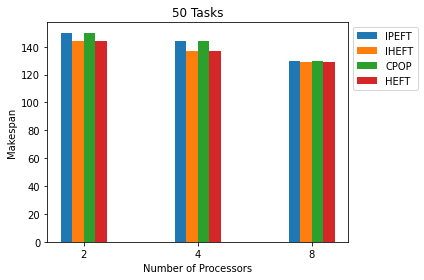

In [13]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np


labels = [2, 4, 8]
ipeftValues = [150, 144, 130]
iheftValues = [144, 137, 129]

x = np.arange(len(labels))  # the label locations
width = 0.10  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - 1.5 * width, ipeftValues, width, label='IPEFT')
rects2 = ax.bar(x - width/2, iheftValues, width, label='IHEFT')
rects1 = ax.bar(x + width/2, ipeftValues, width, label='CPOP')
rects2 = ax.bar(x + 1.5 * width, iheftValues, width, label='HEFT')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Makespan')
ax.set_xlabel('Number of Processors')
ax.set_title('50 Tasks')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(bbox_to_anchor=(1, 1))


# def autolabel(rects):
#     """Attach a text label above each bar in *rects*, displaying its height."""
#     for rect in rects:
#         height = rect.get_height()
#         ax.annotate('{}'.format(height),
#                     xy=(rect.get_x() + rect.get_width() / 2, height),
#                     xytext=(0, 3),  # 3 points vertical offset
#                     textcoords="offset points",
#                     ha='center', va='bottom')


# autolabel(rects1)
# autolabel(rects2)

fig.tight_layout()

plt.show()

In [14]:
# Experiment
from os import listdir
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

class MetricsResult:
  def __init__(self, numTask, numProcessor, compCostVariation, commDataVariation):
    self.numTask = numTask
    self.numProcessor = numProcessor
    self.compCostVariation = compCostVariation
    self.commDataVariation = commDataVariation


class Experiment:
  def __init__(self):
    self.dag = DAG()
    self.numProcessors = [2, 4, 8]
    self.compCostVariations = [2, 10, 20]
    self.commDataVariations = [5, 10]
    self.numTasks = [50] # [50, 100, 300]
    self.baseDiretory = '/content/drive/MyDrive/TCC/Grafos/'

    self.ipeftMakespan = []
    self.ipeftLoadBalance = []
    self.iheftMakespan = []
    self.iheftLoadBalance = []
    self.cpopMakespan = []
    self.cpopLoadBalance = []
    self.heftMakespan = []
    self.heftLoadBalance = []

  def generateGraphs(self):
    for numTask in self.numTasks:
      for i in range(0, 180, 5):
        for numProcessor in self.numProcessors:
          for compCostVariation in self.compCostVariations:
            for commDataVariation in self.commDataVariations:
              graphIndex = str(i).rjust(3, '0')
              graphDiretory = self.baseDiretory + f'stg/{numTask}/rand0{graphIndex}.stg'
              graphCCHPDiretory = self.baseDiretory + f'stg-cchp/{numTask}/rand0{graphIndex}-{numProcessor}-{compCostVariation}-{commDataVariation}.stg'
              self.dag.createCCHP(graphDiretory, graphCCHPDiretory, numProcessor, compCostVariation, commDataVariation)

  def saveResults(self, fileName, results):
    resultsDiretory = self.baseDiretory + f'results/{fileName}'
    file = open(resultsDiretory, 'wb')
    pickle.dump(results, file)
    file.close()

  def loadResults(self, fileName):
    resultsDiretory = self.baseDiretory + f'results/{fileName}'
    file = open(resultsDiretory, 'rb')
    return pickle.load(file)
  
  def runSchedules(self):
    metricsResults = []
    for numTask in self.numTasks:
      for i in range(0, 50, 5):
        for numProcessor in self.numProcessors:
          for compCostVariation in self.compCostVariations:
            for commDataVariation in self.commDataVariations:
              graphIndex = str(i).rjust(3, '0')
              graphCCHPDiretory = self.baseDiretory + f'stg-cchp/{numTask}/rand0{graphIndex}-{numProcessor}-{compCostVariation}-{commDataVariation}.stg'
              env = self.dag.readCCHP(graphCCHPDiretory)
              print(graphCCHPDiretory)

              metricsResult = MetricsResult(numTask, numProcessor, compCostVariation, commDataVariation)

              ipeft = IPEFT(env)
              ipeft.run()
              metricsResult.ipeftMakespan = ipeft.makespan()
              metricsResult.ipeftLoadBalance = ipeft.loadBalance()

              env.resetInstances()
              iheft = IHEFT(env)
              iheft.run()
              metricsResult.iheftMakespan = iheft.makespan()
              metricsResult.iheftLoadBalance = iheft.loadBalance()
          
              env.resetInstances()
              cpop = CPOP(env)
              cpop.run()
              metricsResult.cpopMakespan = cpop.makespan()
              metricsResult.cpopLoadBalance = cpop.loadBalance()
          
              env.resetInstances()
              heft = HEFT(env)
              heft.run()
              metricsResult.heftMakespan = heft.makespan()
              metricsResult.heftLoadBalance = heft.loadBalance()

              metricsResults.append(metricsResult)

    return metricsResults
  
  def plotResults(self):
    labels = [2, 4, 8]
    ipeftValues = [150, 144, 130]
    iheftValues = [144, 137, 129]

    x = np.arange(len(labels))  # the label locations
    width = 0.10  # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - 1.5 * width, ipeftValues, width, label='IPEFT')
    rects2 = ax.bar(x - width/2, iheftValues, width, label='IHEFT')
    rects1 = ax.bar(x + width/2, ipeftValues, width, label='CPOP')
    rects2 = ax.bar(x + 1.5 * width, iheftValues, width, label='HEFT')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Makespan')
    ax.set_xlabel('Number of Processors')
    ax.set_title('50 Tasks')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend(bbox_to_anchor=(1, 1))


    # def autolabel(rects):
    #     """Attach a text label above each bar in *rects*, displaying its height."""
    #     for rect in rects:
    #         height = rect.get_height()
    #         ax.annotate('{}'.format(height),
    #                     xy=(rect.get_x() + rect.get_width() / 2, height),
    #                     xytext=(0, 3),  # 3 points vertical offset
    #                     textcoords="offset points",
    #                     ha='center', va='bottom')


    # autolabel(rects1)
    # autolabel(rects2)

    fig.tight_layout()

    plt.show()

# exp = Experiment()
# results = exp.runSchedules()
# exp.saveResults('test-1', results)
# results = exp.loadResults('test-1')
# for result in results:
#   print(f'{result.numTask}-{result.numProcessor}-{result.compCostVariation}-{result.commDataVariation} {result.iheftLoadBalance}')

In [15]:
def functionalTest():
  dag = DAG()
  # dag.createCCHP('/content/drive/MyDrive/TCC/Grafos/rnc50/50/rand0003.stg', '/content/drive/MyDrive/TCC/Grafos/rnc50/50/FT0003-p1-cchp.stg', 1)

  graphFiles = [
                'topcuoglu-10.stg',
                'alebrahim-10.stg',
                'zhou-10.stg',
                'functional-tests/FT0000-p2-cchp.stg',
                'functional-tests/FT0000-p4-cchp.stg',
                'functional-tests/FT0001-p3-cchp.stg',
                'functional-tests/FT0001-p5-cchp.stg',
                'functional-tests/FT0002-p2-cchp.stg', # Pq o CPOP foi melhor?
                'functional-tests/FT0002-p4-cchp.stg', # Resultado do CPOP estranho
                'functional-tests/FT0003-p1-cchp.stg',
                ]
  
  expectedResults = [
                     [86, 80, 86, 80],
                     [520, 485, 520, 521],
                     [116, 141, 131, 143],
                     [148, 148, 163, 150],
                     [77, 75, 84, 77],
                     [130, 137, 134, 130],
                     [108, 117, 123, 110],
                     [140, 143, 147, 148],
                     [82, 96, 122, 82],
                     [341, 341, 341, 341]
                    ]
  
  envs = []
  for graphFile in graphFiles:
    envs.append(dag.readCCHP('/content/drive/MyDrive/TCC/Grafos/' + graphFile))

  for i in range(len(expectedResults)):
    envs[i].resetInstances()
    ipeft = IPEFT(envs[i])
    expectedResult = expectedResults[i][0]
    result = ipeft.run()
    print('LB', ipeft.loadBalance())
    if (ipeft.makespan() != expectedResult):
      raise Exception(f'IPEFT result error\nIndex: {i}\nReceived: {result}\nExpected: {expectedResult}')

    envs[i].resetInstances()
    iheft = IHEFT(envs[i])
    expectedResult = expectedResults[i][1]
    iheft.run()
    print('LB', iheft.loadBalance())
    if (iheft.makespan() != expectedResult):
      raise Exception(f'IHEFT result error\nIndex: {i}\nReceived: {result}\nExpected: {expectedResult}')

    envs[i].resetInstances()
    cpop = CPOP(envs[i])
    expectedResult = expectedResults[i][2]
    result = cpop.run()
    print('LB', cpop.loadBalance())
    if (cpop.makespan() != expectedResult):
      raise Exception(f'CPOP result error\nIndex: {i}\nReceived: {result}\nExpected: {expectedResult}')

    envs[i].resetInstances()
    heft = HEFT(envs[i])
    expectedResult = expectedResults[i][3]
    result = heft.run()
    print('LB', heft.loadBalance())
    if (heft.makespan() != expectedResult):
      raise Exception(f'HEFT result error\nIndex: {i}\nReceived: {result}\nExpected: {expectedResult}')

functionalTest()


Schedule length =  86
LB 2.224137931034483
Schedule length =  80.0
LB 2.6373626373626373
Schedule length =  86.0
LB 2.064
Schedule length =  80.0
LB 2.181818181818182
Schedule length =  520
LB 1.3848202396804261
Schedule length =  485.0
LB 1.223203026481715
Schedule length =  520
LB 1.3848202396804261
Schedule length =  521.0
LB 1.3837981407702524
Schedule length =  116.0
LB 2.3835616438356166
Schedule length =  141.0
LB 3.9532710280373835
Schedule length =  131.0
LB 2.425925925925926
Schedule length =  143.0
LB 2.4655172413793105
Schedule length =  148.0
LB 1.0033898305084745
Schedule length =  148.0
LB 1.0033898305084745
Schedule length =  163.0
LB 1.0939597315436242
Schedule length =  150.0
LB 1.0067114093959733
Schedule length =  77.0
LB 1.0405405405405406
Schedule length =  75.0
LB 1.048951048951049
Schedule length =  84.0
LB 1.1546391752577319
Schedule length =  77.0
LB 1.0301003344481605
Schedule length =  130.0
LB 1.1926605504587156
Schedule length =  137.0
LB 1.268518518518518